# IEEE CIS Fraud Detection

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score,auc
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from pandas import Series, DataFrame
import xgboost as xgb
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Reading in file

In [2]:
trans_tr = pd.read_csv('C:/Users/aadia/Downloads/ieee-fraud-detection/train_transaction.csv')
trans_test = pd.read_csv('C:/Users/aadia/Downloads/ieee-fraud-detection/test_transaction.csv')
id_tr = pd.read_csv('C:/Users/aadia/Downloads/ieee-fraud-detection/train_identity.csv')
id_test = pd.read_csv('C:/Users/aadia/Downloads/ieee-fraud-detection/test_identity.csv')

In [3]:
#size of train dataset
trans_tr.shape,id_tr.shape

((590540, 394), (144233, 41))

In [4]:
#size of test dataset
trans_test.shape,id_test.shape

((506691, 393), (141907, 41))

# About identity dataset

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
DeviceType,
DeviceInfo,
id12 - id38

In [5]:
id_tr.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
null=(id_tr.isna().sum()/len(id_tr))*100
null[null>20].index

Index(['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34'], dtype='object')

Drop columns with greater than 20% missing values

In [7]:
id_tr=id_tr.drop(['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 
            'id_14', 'id_18', 'id_21','id_22', 'id_23', 'id_24', 
            'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34'],axis=1)

In [8]:
id_tr.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'], dtype='object')

Define numerical and categorical features in the data set

In [9]:
numerical_features=['id_01', 'id_02', 'id_05', 'id_06','id_11','id_13','id_17',
                    'id_19','id_20']
cat_features=['id_12','id_15','id_16','id_28', 'id_29', 'id_31', 
                      'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

Distribution of numerical features

id_01


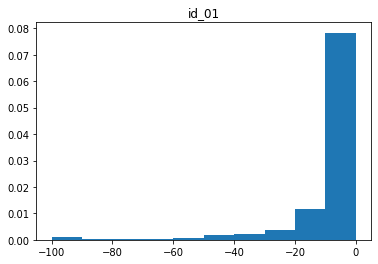

-----------------------------------------
id_02


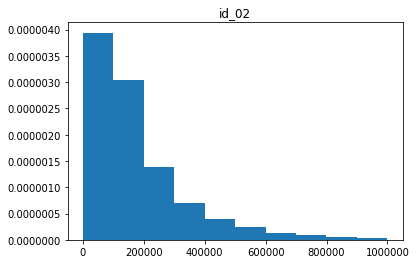

-----------------------------------------
id_05


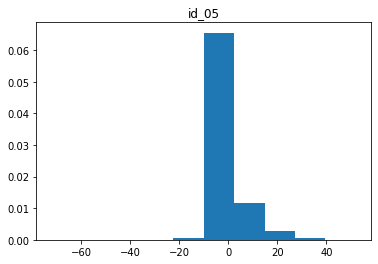

-----------------------------------------
id_06


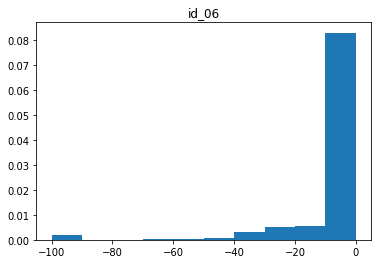

-----------------------------------------
id_11


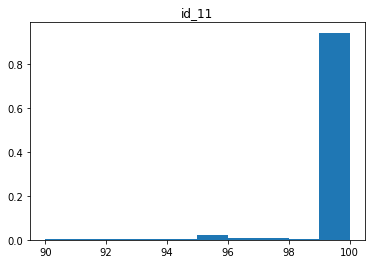

-----------------------------------------
id_13


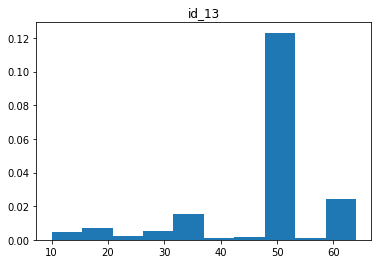

-----------------------------------------
id_17


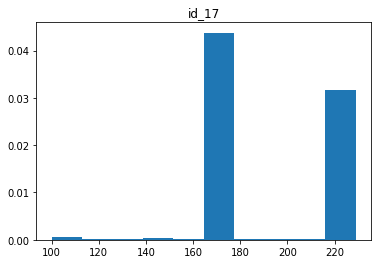

-----------------------------------------
id_19


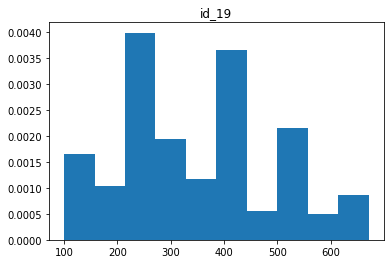

-----------------------------------------
id_20


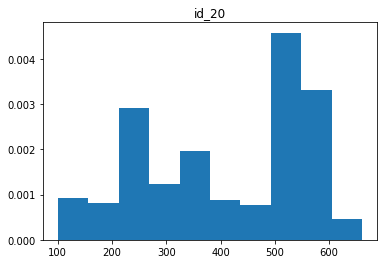

-----------------------------------------


In [10]:
for col in numerical_features: 
    print(col)
    
    num_bins = 10
    plt.hist(id_tr[col], num_bins, normed=1)
    plt.title(col)
    plt.show()
    print('-----------------------------------------')


Count distribution of categorical features

id_12


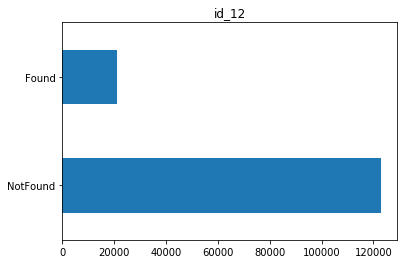

-----------------------------------------
id_15


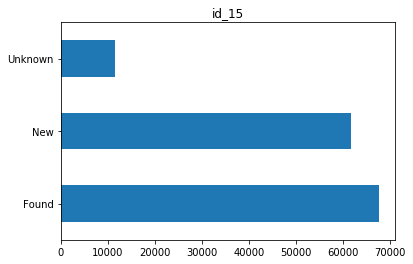

-----------------------------------------
id_16


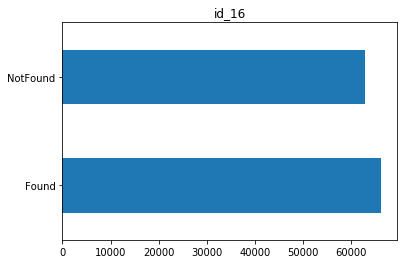

-----------------------------------------
id_28


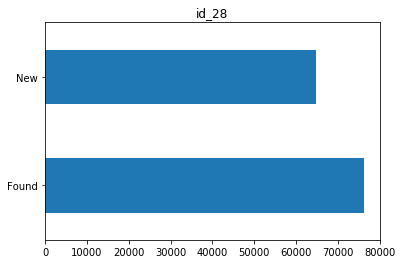

-----------------------------------------
id_29


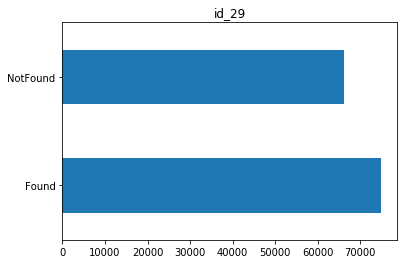

-----------------------------------------
id_31


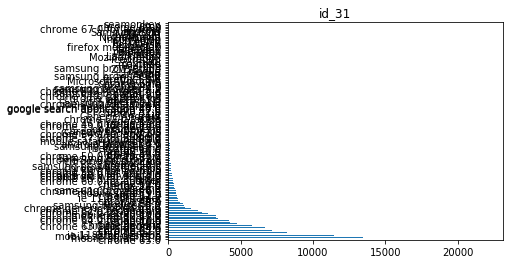

-----------------------------------------
id_35


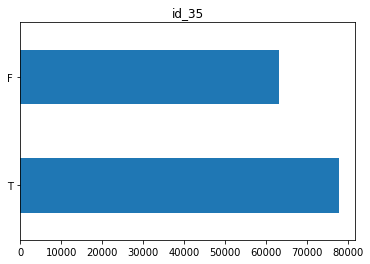

-----------------------------------------
id_36


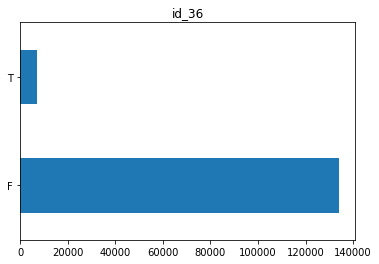

-----------------------------------------
id_37


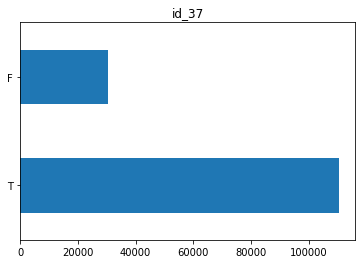

-----------------------------------------
id_38


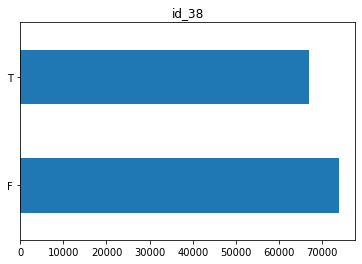

-----------------------------------------
DeviceType


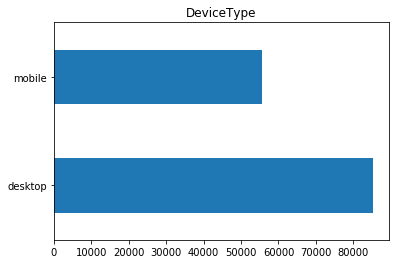

-----------------------------------------
DeviceInfo


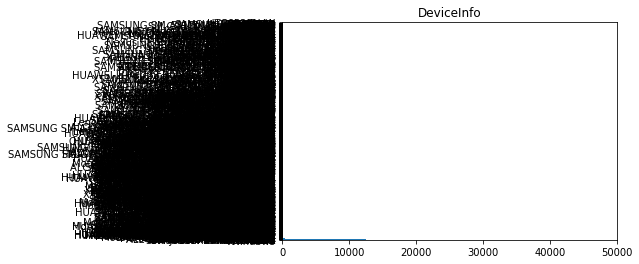

-----------------------------------------


In [11]:
for col in cat_features: 
    print(col)
    
    count=id_tr[col].value_counts().plot(kind='barh')
    plt.title(col)
    plt.show()
    print('-----------------------------------------')


id_31 seems to be browser type

# About transaction dataset


    TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
    TransactionAMT: transaction payment amount in USD
    ProductCD: product code, the product for each transaction
    card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
    addr: address
    dist: distance
    P_ and (R__) emaildomain: purchaser and recipient email domain
    C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
    D1-D15: timedelta, such as days between previous transaction, etc.
    M1-M9: match, such as names on card and address, etc.
    Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
ProductCD,
card1 - card6,
addr1, addr2,
Pemaildomain Remaildomain,
M1 - M9

In [12]:
trans_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

Drop columns with greater than 1% missing values

In [ ]:
null_tr=(trans_tr.isna().sum()/len(trans_tr))*100
drop=null_tr[null_tr>1].reset_index()

In [ ]:
trans_tr=trans_tr.drop(list(drop['index']),axis=1)
trans_tr.head()

In [ ]:
trans_tr.columns

Define numerical and categorical features in the data set

In [ ]:
num_features=['TransactionAmt','card1', 'card3','card5',"C1","C2","C3",
                    "C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","D1",
                   "V95","V96","V97","V98","V99","V100","V101","V102","V103","V104","V105",
                    "V106","V107","V108","V109","V110","V111","V112","V113","V114","V115",
                    "V116","V117","V118","V119","V120","V121","V122","V123","V124","V125",
                    "V126","V127","V128","V129","V130","V131","V132","V133","V134","V135",
                    "V136","V137","V279","V280","V281","V282","V283","V284","V285","V286",
                    "V287","V288","V289","V290","V291","V292","V293","V294","V295","V296",
                    "V297","V298","V299","V300","V301","V302","V303","V304","V305","V306",
                    "V307","V308","V309","V310","V311","V312","V313","V314","V315","V316",
                    "V317","V318","V319","V320","V321"]

categorical_features=['ProductCD','card4','card6']

Distribution of numerical features

In [ ]:
for col in num_features: 
    print(col)
    
    num_bins = 10
    plt.hist(trans_tr[col], num_bins, normed=1)
    plt.title(col)
    plt.show()
    print('-----------------------------------------')

Count distribution of categorical variables

In [ ]:
for col in categorical_features: 
    print(col)
    
    count_tr=trans_tr[col].value_counts().plot(kind='barh')
    plt.title(col)
    plt.xlabel('Count of transactions')
    plt.ylabel('Type')
    plt.show()
    print('-----------------------------------------')

Card 4 seems to be card company details and card 6 seems to be type of card

# Time based analysis

In [ ]:
plt.hist(trans_tr['TransactionDT'], label='train');
plt.hist(trans_test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transaction dates');

A very important idea: it seems that train and test transaction dates don't overlap, so we would need to keep this in mind when we split for validation during model building. This was already noted in another kernel: https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

# Merging the data sets

Before doing any further analysis, let us now merge the two data sets and create one train and one test set.

In [ ]:
x_train=pd.merge(trans_tr, id_tr, on='TransactionID', how='left')

Before merging the test sets, let us first drop the columns we dropped off in the train set.

In [ ]:
#identity test set
id_test=id_test.drop(['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 
            'id_14', 'id_18', 'id_21','id_22', 'id_23', 'id_24', 
            'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34'],axis=1)

In [ ]:
#transaction test set
trans_test=trans_test.drop(list(drop['index']),axis=1)

In [ ]:
x_test=pd.merge(trans_test, id_test, on='TransactionID', how='left')

In [ ]:
y_train=x_train['isFraud']
x_train=x_train.drop('isFraud',axis=1)

In [ ]:
x_train.shape,x_test.shape,y_train.shape

Sanity check - check if there are any columns in the merged set with greater than 20% missing data

Train set

In [ ]:
null_train=(x_train.isna().sum()/len(x_train))*100
drop_train=null_train[null_train>20].reset_index()

In [ ]:
drop_train.head()

Though we cleaned the identity and transaction files seperately, there seems to be missing values that were created when the tables were merged (majorly id columns). Filling it with -999

In [ ]:
x_train=x_train.fillna(-999)

Checking for test set

In [ ]:
null_test=(x_test.isna().sum()/len(x_test))*100
drop_test=null_test[null_test>20].reset_index()

In [ ]:
drop_test.head()

Once again, the id variables. Filling it with -999

In [ ]:
x_test=x_test.fillna(-999)

In [ ]:
numerical_features=['id_01', 'id_02', 'id_05', 'id_06','id_11','id_13','id_17',
                    'id_19','id_20','TransactionAmt','card1', 'card3','card5',"C1","C2","C3",
                    "C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","D1",
                   "V95","V96","V97","V98","V99","V100","V101","V102","V103","V104","V105",
                    "V106","V107","V108","V109","V110","V111","V112","V113","V114","V115",
                    "V116","V117","V118","V119","V120","V121","V122","V123","V124","V125",
                    "V126","V127","V128","V129","V130","V131","V132","V133","V134","V135",
                    "V136","V137","V279","V280","V281","V282","V283","V284","V285","V286",
                    "V287","V288","V289","V290","V291","V292","V293","V294","V295","V296",
                    "V297","V298","V299","V300","V301","V302","V303","V304","V305","V306",
                    "V307","V308","V309","V310","V311","V312","V313","V314","V315","V316",
                    "V317","V318","V319","V320","V321"]
cat_features=['id_12','id_15','id_16','id_28', 'id_29', 'id_31', 
                      'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
              'ProductCD','card4','card6']

# Imbalance in the dataset

In [ ]:
y_train.value_counts().plot(kind='bar')
plt.title('Not Fraud vs Fraud transactions')
plt.xlabel('Classes')
plt.ylabel('Count of transactions')

In [ ]:
(y_train.value_counts()/len(y_train))*100

Clear class imbalance problem. 96.5% of transactions are not fraud and 3.5% transactions are only fraud. This is obviously expected and our goal is to correctly identify a fraud transaction.

# PCA

# Feature Engineering